In [ ]:
"""Load packages"""
#test 

%pip install geopandas matplotlib contextily

import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import pandas as pd
from IPython.display import display
import numpy as np
import re


Note: you may need to restart the kernel to use updated packages.


In [91]:
"""Load data"""

# List of file names
files = ["UCMR3_All.txt", "UCMR4_All.txt", "UCMR5_All.txt"]

# Read all files into a list of DataFrames
dfs = [pd.read_csv(file, sep="\t", encoding="latin1") for file in files]

df = pd.concat(dfs, ignore_index=True)

In [ ]:
"""Data overview 1"""

# Display dataset overview
print("\n📌 Dataset Shape (Rows, Columns):")
print(df.shape)

print("\n📌 Column Names:")
print(df.columns.tolist())

print("\n📌 General Info:")
df.info()  

print("\n📌 Missing Values Count per Column:")
print(df.isna().sum())

print("\n📌 Percentage of Missing Values per Column:")
print(df.isna().mean() * 100)

print("\n📌 Unique Value Count per Column:")
print(df.nunique())

print("\n📌 Summary Statistics for Categorical Columns:")
print(df.describe(include="object"))

print("\n📌 Number of Duplicate Rows:")
print(df.duplicated().sum())

print("\n📌 Columns with Only One Unique Value:")
print(df.nunique()[df.nunique() == 1])


📌 Dataset Shape (Rows, Columns):
(3363695, 24)

📌 Column Names:
['PWSID', 'PWSName', 'Size', 'FacilityID', 'FacilityName', 'FacilityWaterType', 'SamplePointID', 'SamplePointName', 'SamplePointType', 'AssociatedFacilityID', 'AssociatedSamplePointID', 'CollectionDate', 'SampleID', 'Contaminant', 'MRL', 'Units', 'MethodID', 'AnalyticalResultsSign', 'AnalyticalResultValue', 'SampleEventCode', 'MonitoringRequirement', 'Region', 'State', 'UCMR1SampleType']

📌 General Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3363695 entries, 0 to 3363694
Data columns (total 24 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   PWSID                    object 
 1   PWSName                  object 
 2   Size                     object 
 3   FacilityID               object 
 4   FacilityName             object 
 5   FacilityWaterType        object 
 6   SamplePointID            object 
 7   SamplePointName          object 
 8   SamplePointType          obje

In [ ]:
"""Data overview 2: list of unique values per column"""

for col in df.columns:
    unique_values = df[col].unique()  # Get unique values
    print(f"\n📌 Unique values in column: {col} ({len(unique_values)} unique values)")
    print(unique_values[:10])  # Show only first 10 unique values for readability


📌 Unique values in column: PWSID (11007 unique values)
['010106001' '010109005' '055293201' '055294506' '055295003' '055295310'
 '055295401' '063500110' '063501116' '063506008']

📌 Unique values in column: PWSName (16507 unique values)
['Mashantucket Pequot Water System' 'Mohegan Tribal Utility Authority'
 'Mt. Pleasant' 'Sioux Trail' 'South-Central Water System' 'Dry Town'
 'Lac Du Flambeau' 'Jemez Pueblo' 'San Ildefonso Pueblo/Pajaritos'
 'Mescalero Apache Tribe / Inn of the Moun']

📌 Unique values in column: Size (2 unique values)
['L' 'S']

📌 Unique values in column: FacilityID (18163 unique values)
[6 202 17 90001 51 676 783 1490 1559 1562]

📌 Unique values in column: FacilityName (25794 unique values)
['MPTN WTP' 'Distribution System' 'Blended Tank' 'Treatment Plant'
 'Giinedin Pumphouse' 'Main System Wells #9 & #10'
 'Main System Wells #6, #7 & #8' 'Filtration Plant - Well 2'
 'Black Mesa Well #1' 'Black Mesa Well #2']

📌 Unique values in column: FacilityWaterType (4 unique val

In [ ]:
"""Data preprocessing 1: drop cols, filter for PFAS, add cols for Year and Month, calculate relative contamination levels"""


# Drop cols
### Add code here later, the df is small enough to handle for now

# Filter data for PFAS contaminants
pfas_list = [
    "PFOA", "PFBS", "PFHpA", "PFHxS", "PFNA", "PFOS", "9Cl-PF3ONS", "NEtFOSAA",
    "PFTrDA", "ADONA", "PFTA", "NMeFOSAA", "PFHxA", "HFPO-DA", "PFPeS", "PFHpS",
    "PFDoA", "PFMPA", "11Cl-PF3OUdS", "PFDA", "PFEESA", "PFUnA", "PFBA", "PFPeA",
    "8:2 FTS", "NFDHA", "6:2 FTS", "4:2 FTS", "PFMBA"
]

df_PFAS = df[df["Contaminant"].isin(pfas_list)].copy()  


# Convert 'CollectionDate' to datetime, drop rows with missing datetime string
# Add cols for Year and Month 
df_PFAS["CollectionDate"] = pd.to_datetime(df_PFAS["CollectionDate"], errors='coerce')
df_PFAS = df_PFAS.dropna(subset=["CollectionDate"]) 

df_PFAS["Year"] = df_PFAS["CollectionDate"].dt.year
df_PFAS["Month"] = df_PFAS["CollectionDate"].dt.month


# Add cols for MRL level exceeded: Count '<' and '=' occurrences and create seperate columns, add a col for count of both (total)
df_PFAS.loc[:, 'Count_Less_Than'] = (df_PFAS['AnalyticalResultsSign'] == '<').astype(int)
df_PFAS.loc[:, 'Count_Equals'] = (df_PFAS['AnalyticalResultsSign'] == '=').astype(int)
df_PFAS.loc[:, "Total_Values"] = df_PFAS["Count_Less_Than"] + df_PFAS["Count_Equals"]

# Add a column for proportion of contaminated samples
df_PFAS['Equals_Per_Total'] = df_PFAS['Count_Equals'] / df_PFAS['Total_Values']


# Add col for Relative Contamination level (delta AnalyticalResultValue / MRL); only for values with AnalyticalResultsSign "="
# This divides the measured value for samples exceeding the threshold MRL, by the MRL value
# Result is a measure how much the MRL is exceeded
df_PFAS.loc[df_PFAS["AnalyticalResultsSign"] == "=", "Relative_Contamination_Level"] = (
    df_PFAS["AnalyticalResultValue"] / df_PFAS["MRL"]
)


print("\n📌 Processed data -- General Info:")
df_PFAS.info()  

display(df_PFAS)



📌 Processed data -- General Info:
<class 'pandas.core.frame.DataFrame'>
Index: 1537584 entries, 10 to 3363694
Data columns (total 31 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   PWSID                         1537584 non-null  object        
 1   PWSName                       1537584 non-null  object        
 2   Size                          1537584 non-null  object        
 3   FacilityID                    1537526 non-null  object        
 4   FacilityName                  1537555 non-null  object        
 5   FacilityWaterType             1537584 non-null  object        
 6   SamplePointID                 1537584 non-null  object        
 7   SamplePointName               1537584 non-null  object        
 8   SamplePointType               1537584 non-null  object        
 9   AssociatedFacilityID          221831 non-null   float64       
 10  AssociatedSamplePointID       22183

,PWSID,PWSName,Size,FacilityID,FacilityName,FacilityWaterType,SamplePointID,SamplePointName,SamplePointType,AssociatedFacilityID,...,Region,State,UCMR1SampleType,Year,Month,Count_Less_Than,Count_Equals,Total_Values,Equals_Per_Total,Relative_Contamination_Level
10,010106001,Mashantucket Pequot Water System,L,6,MPTN WTP,GU,D11,WTP EPTDS,EP,202.0,...,1,01,NaN,2015,3,1,0,1,0.0,NaN
11,010106001,Mashantucket Pequot Water System,L,6,MPTN WTP,GU,D11,WTP EPTDS,EP,202.0,...,1,01,NaN,2015,3,1,0,1,0.0,NaN
12,010106001,Mashantucket Pequot Water System,L,6,MPTN WTP,GU,D11,WTP EPTDS,EP,202.0,...,1,01,NaN,2015,3,1,0,1,0.0,NaN
13,010106001,Mashantucket Pequot Water System,L,6,MPTN WTP,GU,D11,WTP EPTDS,EP,202.0,...,1,01,NaN,2015,3,1,0,1,0.0,NaN
14,010106001,Mashantucket Pequot Water System,L,6,MPTN WTP,GU,D11,WTP EPTDS,EP,202.0,...,1,01,NaN,2015,3,1,0,1,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3363690,WY5680122,USAF F.E. WARREN AFB,S,20001,Sampling Station,MX,EP1,Facility 930 - Booker Road and Cheyenne Road,EP,NaN,...,8,WY,NaN,2024,9,1,0,1,0.0,NaN
3363691,WY5680122,USAF F.E. WARREN AFB,S,20001,Sampling Station,MX,EP1,Facility 930 - Booker Road and Cheyenne Road,EP,NaN,...,8,WY,NaN,2024,9,1,0,1,0.0,NaN
3363692,WY5680122,USAF F.E. WARREN AFB,S,20001,Sampling Station,MX,EP1,Facility 930 - Booker Road and Cheyenne Road,EP,NaN,...,8,WY,NaN,2024,9,1,0,1,0.0,NaN
3363693,WY5680122,USAF F.E. WARREN AFB,S,20001,Sampling Station,MX,EP1,Facility 930 - Booker Road and Cheyenne Road,EP,NaN,...,8,WY,NaN,2024,9,1,0,1,0.0,NaN


In [ ]:
"""Data preprocessing 2: Create seperate data frames for 2024, and for Aggregation per state (incl coordinates)"""

# Create seperate file for 2024 data only
df_PFAS_2024 = df_PFAS[df_PFAS["CollectionDate"].dt.year == 2024].copy()

# Aggregate data per state
df_states = df_PFAS_2024.groupby("State").agg(
    Total_Values=('Total_Values', 'sum'),
    Count_Less_Than=('Count_Less_Than', 'sum'),
    Count_Equals=('Count_Equals', 'sum'),
    Max_Relative_Contamination=('Relative_Contamination_Level', 'max'),
    Mean_Relative_Contamination=('Relative_Contamination_Level', 'mean')
).reset_index()

# Remove non-state territories (i.e. numbers instead of states in state col)
df_states = df_states.iloc[8:].reset_index(drop=True)

# Add col for contaminated samples: "samples exceeding MRL" / "total samples"
df_states["Equals_Per_Total"] = df_states["Count_Equals"] / df_states["Total_Values"]
df_states.insert(4, "Equals_Per_Total", df_states.pop("Equals_Per_Total"))



"""All below: Code to add (lognitudinal, latiduninal) coordinates to states data frame"""
# US territories and DC are ignored

# Scrape state coordinates
url = "https://www.latlong.net/category/states-236-14.html"
tables = pd.read_html(url)  # Reads all tables on the page
df_coords = tables[0]  # The first table contains the data
df_coords.columns = ["State_long", "Latitude", "Longitude"]  # Rename columns

# Clean up state names: Remove variations like ", usa", "the us", etc.
df_coords["State_long"] = df_coords["State_long"].str.lower().str.strip()
df_coords["State_long"] = df_coords["State_long"].apply(lambda x: re.sub(r",? (the )?us(a)?$", "", x))



# Create a Reference DataFrame with state abbreviations to match with our data and add abbreviations to df_coords
state_abbreviations = pd.DataFrame({
    'State_long': ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia',
              'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
              'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey',
              'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina',
              'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'],
    'State': ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA',
                     'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD',
                     'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ',
                     'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC',
                     'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY']
})

state_abbreviations["State_long"] = state_abbreviations["State_long"].str.strip().str.lower()
df_coords = pd.merge(df_coords, state_abbreviations, on="State_long", how="left")
df_coords.drop(columns=['State_long'], inplace=True)

# Add coordinates to our data frame df_states
if "Longitude" not in df_states.columns or "Latitude" not in df_states.columns:
    df_states = pd.merge(df_states, df_coords, on="State", how="left")

    # Move "Latitude" and "Longitude" to the second position (index 1)
    df_states.insert(1, "Latitude", df_states.pop("Latitude"))
    df_states.insert(2, "Longitude", df_states.pop("Longitude"))


display(df_states)

,State,Latitude,Longitude,Total_Values,Count_Less_Than,Count_Equals,Equals_Per_Total,Max_Relative_Contamination,Mean_Relative_Contamination
0,AK,66.160507,-153.369141,1479,1462,17,0.011494,10.175000,2.423039
1,AL,32.318230,-86.902298,22238,21556,682,0.030668,51.800000,3.803844
2,AR,34.799999,-92.199997,5764,5764,0,0.000000,NaN,NaN
3,AS,NaN,NaN,1193,1192,1,0.000838,1.033333,1.033333
4,AZ,34.048927,-111.093735,23229,22950,279,0.012011,48.000000,3.835430
5,CA,36.778259,-119.417931,86996,85634,1362,0.015656,83.400000,2.376597
6,CO,39.113014,-105.358887,10743,10586,157,0.014614,30.500000,2.106348
7,CT,41.599998,-72.699997,5473,5292,181,0.033071,5.000000,1.449641
8,DC,NaN,NaN,348,342,6,0.017241,1.566667,1.316667
9,DE,39.000000,-75.500000,4081,3953,128,0.031365,35.333333,3.826458


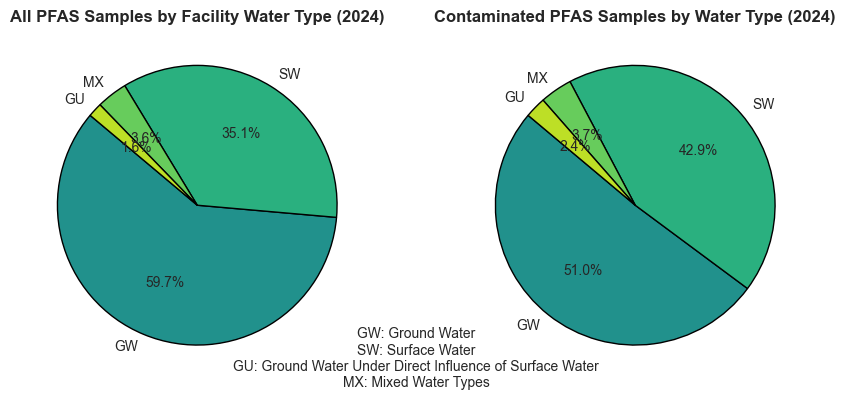

In [ ]:
"""Visualization: Pie chart of sample water sources: all samples vs only contaminated samples (PFAS only, 2024, all states)"""

# Count occurrences of each FacilityWaterType (all values and confirmed contaminated)
water_type_counts = df_PFAS_2024["FacilityWaterType"].value_counts()
water_type_confirmed = df_PFAS_2024[df_PFAS_2024["AnalyticalResultsSign"] == "="]["FacilityWaterType"].value_counts()

# Plot
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
viridis_cmap = sns.color_palette("viridis", as_cmap=True)

colors = [viridis_cmap(i) for i in np.linspace(0.5, 0.9, len(water_type_counts))]  # Sample from light range

# First Pie Chart - All samples
axes[0].pie(
    water_type_counts, 
    labels=water_type_counts.index,  
    autopct="%1.1f%%",
    colors=colors,
    startangle=140,
    wedgeprops={"edgecolor": "black"}
)
axes[0].set_title("All PFAS Samples by Facility Water Type (2024)", fontsize=12, fontweight="bold")

# Second Pie Chart - Only Confirmed Contamination ( AnalyticalResultsSign = "=")
axes[1].pie(
    water_type_confirmed, 
    labels=water_type_confirmed.index,  
    autopct="%1.1f%%",
    colors=colors,  
    startangle=140,
    wedgeprops={"edgecolor": "black"}
)
axes[1].set_title("Contaminated PFAS Samples by Water Type (2024)", fontsize=12, fontweight="bold")

legend_text = """GW: Ground Water
SW: Surface Water
GU: Ground Water Under Direct Influence of Surface Water
MX: Mixed Water Types"""
fig.text(0.5, 0.02, legend_text, ha="center", fontsize=10)

plt.tight_layout()
plt.show()


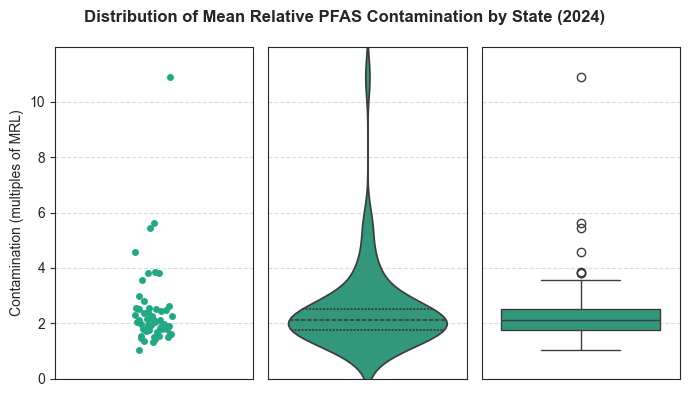

In [119]:
"""Visualization: Strip, violin, bar plots of mean relative contamination (2024)"""

# Set general plot style
sns.set_style("ticks")

# Create a single-row, three-column figure layout
fig, axes = plt.subplots(1, 3, figsize=(7, 4))

# Global y-axis limits
y_min = 0
y_max = df_states["Mean_Relative_Contamination"].max() * 1.1

# Strip plot for Mean Relative Contamination
main_color = sns.color_palette("viridis", as_cmap=True)(0.6)
sns.stripplot(y=df_states["Mean_Relative_Contamination"], ax=axes[0], jitter=True, color=main_color)
axes[0].set_ylabel("Contamination (multiples of MRL)")

# Violin plot for Mean Relative Contamination
sns.violinplot(y=df_states["Mean_Relative_Contamination"], ax=axes[1], inner="quartile", color=main_color)
axes[1].set_ylabel("")
axes[1].set_yticklabels([])  
axes[1].tick_params(left=False)  

# Box plot for Mean Relative Contamination
sns.boxplot(y=df_states["Mean_Relative_Contamination"], ax=axes[2], color=main_color)
axes[2].set_ylabel("")
axes[2].set_yticklabels([])  
axes[2].tick_params(left=False)  

# Set same y-axis range for all subplots and add horizontal gridlines
for ax in axes:
    ax.set_xlabel("")
    ax.set_xticks([])
    ax.set_ylim(y_min, y_max)  
    ax.yaxis.grid(True, linestyle="--", alpha=0.7)  

fig.suptitle("Distribution of Mean Relative PFAS Contamination by State (2024)", fontsize=12, fontweight="bold")

plt.tight_layout()
plt.show()

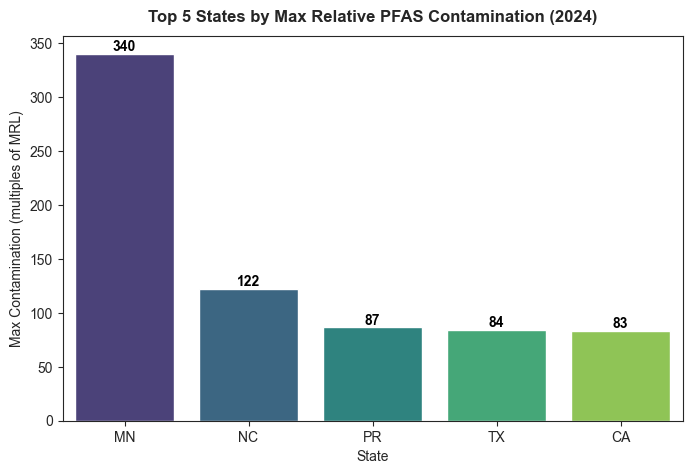

In [ ]:
"""Visualization: Plot the top 5 states with the highest Max_Relative_Contamination (2024)"""

# Get the top 5 states with the highest Max_Relative_Contamination
top5_states = df_states.nlargest(5, "Max_Relative_Contamination").copy()

plt.figure(figsize=(8, 5)) 
ax = sns.barplot(
    data=top5_states,
    x="State",
    y="Max_Relative_Contamination",
    palette="viridis",
    legend=False,
    hue="State"
)

# Annotate values on bars
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.0f}",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center",
        va="bottom",
        fontsize=10, 
        fontweight="bold",
        color="black"
    )

plt.title("Top 5 States by Max Relative PFAS Contamination (2024)", fontsize=12, fontweight="bold", pad=10)
plt.xlabel("State", fontsize=10)
plt.ylabel("Max Contamination (multiples of MRL)", fontsize=10)


plt.show()


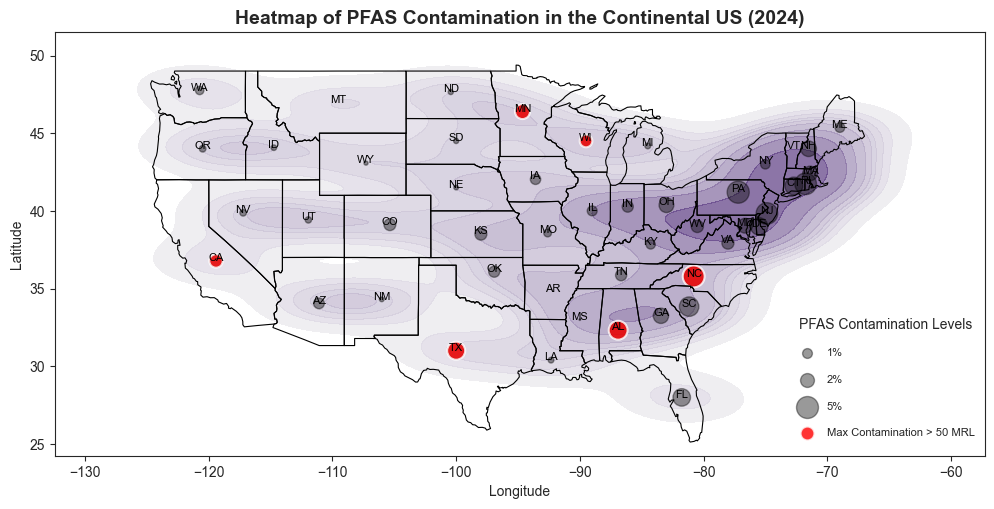

In [121]:
"""Visualization: Create heat map of PFAS contamination -- Percentage of Samples Exceeding MRL by State (2024)"""

# Filter df_states to include only continental U.S. states
non_continental_fips = ["02", "15", "72"] # Alaska, Hawaii, PRico

# Load US states borders from GeoJSON
url = "https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json"
usa = gpd.read_file(url)
usa_continental = usa[~usa["id"].isin(non_continental_fips)] # FIlter out non-continental states

# Create figure
fig, ax = plt.subplots(figsize=(12, 8))

usa_continental.boundary.plot(ax=ax, linewidth=0.8, color="black")

# Create the heatmap
blue_tone = sns.color_palette("viridis", as_cmap=True)(0.1)  

sns.kdeplot(
    data=df_states_cont,
    x="Longitude",
    y="Latitude",
    cmap= sns.light_palette(blue_tone, as_cmap=True),
    fill=True,
    bw_adjust=0.5,
    alpha=0.7,
    thresh=0.05,
    ax=ax
)

# Define scaling for legend
scale_factor = 5000  # Match the scatter size scaling
sizes = [ 0.01, 0.02, 0.05]  # Example PFAS detection levels
legend_labels = [f"{s*100:.00f}%" for s in sizes]

# Overlay PFAS contamination points
plt.scatter(
    df_states_cont["Longitude"],
    df_states_cont["Latitude"],
    s=df_states_cont["Equals_Per_Total"] * 5000,  # Scale based on detections
    color="black",
    alpha=0.4
)

# Highlight states where Max_Relative_Contamination > 50
high_contamination = df_states_cont[df_states_cont["Max_Relative_Contamination"] > 50]

plt.scatter(
    high_contamination["Longitude"],
    high_contamination["Latitude"],
    s=high_contamination["Equals_Per_Total"] * scale_factor * 1.2,  # Slightly bigger size
    color="red",
    edgecolor="white",
    linewidth=1.5,
    alpha=0.8,
    label="Max Contamination > 50"
)

# Add state labels
for _, row in df_states_cont.iterrows():
    ax.text(row["Longitude"], row["Latitude"], row["State"], fontsize=8, ha="center", color="black")

# Create a custom legend for scatter sizes
legend_handles = [
    plt.scatter([], [], s=s * scale_factor, color="black", alpha=0.4, label=label)
    for s, label in zip(sizes, legend_labels)
]


# Add the high-contamination legend entry
legend_handles.append(
    plt.scatter([], [], s=100, color="red", edgecolor="white", linewidth=1.5, alpha=0.8, label="Max Contamination > 50 MRL")
)
# Add the legend
ax.legend(handles=legend_handles, title="PFAS Contamination Levels", bbox_to_anchor=(1, 0.35), fontsize=8, frameon=False,labelspacing=1.5 )

# Set labels and title
plt.title("Heatmap of PFAS Contamination in the Continental US (2024)", fontsize=14, fontweight="bold")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()


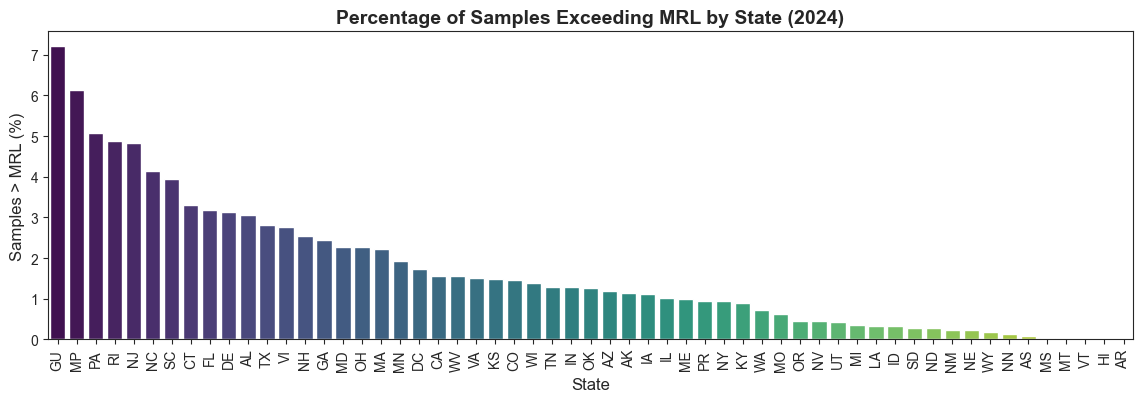

In [126]:
"""Visualization: Create historgram of PFAS Contamination -- Percentage of Samples Exceeding MRL by State (2024)"""

plt.figure(figsize=(14, 4))

# Convert y-axis to percentage and sort by value
df_sorted = df_states.sort_values(by="Equals_Per_Total", ascending=False).copy()

sns.barplot(
    data=df_sorted,
    x="State",
    y=df_sorted["Equals_Per_Total"] * 100, 
    palette="viridis",
    hue = "State",
    legend = False
)

plt.xticks(rotation=90)

plt.title("Percentage of Samples Exceeding MRL by State (2024)", fontsize=14, fontweight="bold")
plt.ylabel("Samples > MRL (%)", fontsize=12) 
plt.xlabel("State", fontsize=12)

plt.show()


,Year,Total_Values,Count_Less_Than,Count_Equals,Max_Relative_Contamination,Mean_Relative_Contamination,Equals_Per_Total,Max_Relative_Contamination_N,Mean_Relative_Contamination_N,Equals_Per_Total_N
0,2014,1536,1373,163,32.5,4.378408,10.611979,1.000000,1.000000,1.000000
1,2024,10743,10586,157,30.5,2.106348,1.461417,0.938462,0.481076,0.137714


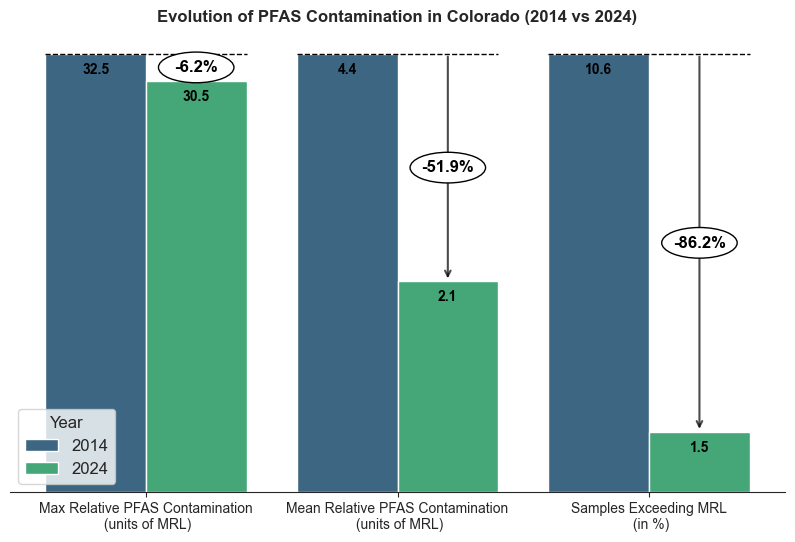

In [248]:
"""Visualization: Plot PFAS contamination levels (samples exceeding MRL) for COLORADO over time"""

# FIlter for Colorado
df_PFAS_CO = df_PFAS[df_PFAS["State"] == "CO"]

# Filter for 2014 and 2024
df_PFAS_CO_2014_2024 = df_PFAS_CO[(df_PFAS_CO["Year"] == 2014) | (df_PFAS_CO["Year"] == 2024)]

# Aggregate data per year
df_years = df_PFAS_CO_2014_2024.groupby("Year").agg(
    Total_Values=('Total_Values', 'sum'),
    Count_Less_Than=('Count_Less_Than', 'sum'),
    Count_Equals=('Count_Equals', 'sum'),
    Max_Relative_Contamination=('Relative_Contamination_Level', 'max'),
    Mean_Relative_Contamination=('Relative_Contamination_Level', 'mean')
).reset_index()

# Add a relative column, contaminated samples / all samples
df_years["Equals_Per_Total"] = df_years['Count_Equals'] / df_years['Total_Values'] * 100

# Add normalized values for plotting
max_relative_cont_2014 = df_years.loc[df_years["Year"] == 2014, "Max_Relative_Contamination"].values[0]
mean_relative_cont_2014 = df_years.loc[df_years["Year"] == 2014, "Mean_Relative_Contamination"].values[0]
equals_per_total_2014 = df_years.loc[df_years["Year"] == 2014, "Equals_Per_Total"].values[0] 


df_years["Max_Relative_Contamination_N"] = df_years["Max_Relative_Contamination"] / max_relative_cont_2014
df_years["Mean_Relative_Contamination_N"] = df_years["Mean_Relative_Contamination"] / mean_relative_cont_2014
df_years["Equals_Per_Total_N"] = df_years["Equals_Per_Total"] / equals_per_total_2014 


# Display the aggregated DataFrame
display(df_years)


"""Create the bar comparison plot"""

df_years["Max Relative PFAS Contamination\n (units of MRL)"] = df_years["Max_Relative_Contamination_N"]
df_years["Mean Relative PFAS Contamination\n (units of MRL)"] = df_years["Mean_Relative_Contamination_N"]
df_years["Samples Exceeding MRL\n (in %)"] = df_years["Equals_Per_Total_N"]

# Define the normalized metrics for plotting
normalized_metrics = ["Max Relative PFAS Contamination\n (units of MRL)", "Mean Relative PFAS Contamination\n (units of MRL)", "Samples Exceeding MRL\n (in %)"]

# Melt the DataFrame for seaborn
df_melted = df_years.melt(id_vars=["Year"], value_vars=normalized_metrics, var_name="Metric", value_name="Value")

# Create the seaborn bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_melted, x="Metric", y="Value", hue=df_melted["Year"].astype(str), palette="viridis")

# Convert df_years into a pivot table for easier lookup
df_pivot_norm = df_years.set_index("Year")[normalized_metrics].T  # Normalized values for plotting
df_pivot_orig = df_years.set_index("Year")[original_metrics].T  # Non-normalized values for annotations
df_pivot_norm["Percent_Change"] = ((df_pivot_norm[2024] - df_pivot_norm[2014]) / df_pivot_norm[2014]) * 100  # Compute % change

# Add value labels, arrows, and percentage change annotations
for i, (norm_metric, orig_metric) in enumerate(zip(normalized_metrics, original_metrics)):
    values_norm = df_pivot_norm.loc[norm_metric, [2014, 2024]].values  # Normalized values for bar heights
    values_orig = df_pivot_orig.loc[orig_metric, [2014, 2024]].values  # Non-normalized values for annotations
    percent_change = df_pivot_norm.loc[norm_metric, "Percent_Change"]  # Percentage change

    # Find x positions of bars for annotation
    bar1 = ax.patches[i]  # First bar (2014)
    bar2 = ax.patches[i + len(normalized_metrics)]  # Second bar (2024)
    
    # Add non-normalized value labels on top of bars
    # Adjust text position to be inside the bar at the top
    ax.annotate(f"{values_orig[0]:.1f}", 
                (bar1.get_x() + bar1.get_width() / 2, bar1.get_height() - 0.02),  # Move text inside the bar
                ha='center', va='top', fontsize=10, fontweight="bold", color="black")

    ax.annotate(f"{values_orig[1]:.1f}", 
                (bar2.get_x() + bar2.get_width() / 2, bar2.get_height() - 0.02),  # Move text inside the bar
                ha='center', va='top', fontsize=10, fontweight="bold", color="black")


    # Calculate arrow position
    x_start = bar1.get_x() + bar1.get_width() * 1.5  # Middle of first bar
    x_end = bar2.get_x() + bar2.get_width() / 2  # Middle of second bar
    y_start = bar1.get_height() * 1.0  # Slightly above first bar
    y_end = bar2.get_height() + 0.00  # Slightly above second bar

    # Draw an arrow **in the background** (before ellipses and text)
    ax.annotate("", xy=(x_end, y_end), xytext=(x_start, y_start),
                arrowprops=dict(arrowstyle="->", lw=1.5, color="black", alpha=0.7), zorder=1)

    # Calculate position for the percentage annotation
    mid_x = (x_start + x_end) / 2  # Midpoint between bars
    mid_y = (y_start + y_end) / 2  # Midpoint along the arrow

    # Draw an ellipse (oval) **on top of the arrow**
    ellipse = patches.Ellipse((mid_x, mid_y), width=0.3, height=0.07, 
                              edgecolor="black", facecolor="white", linewidth=1, zorder=2)
    ax.add_patch(ellipse)

    # Add percentage change text **on top of the ellipse**
    ax.annotate(f"{percent_change:.1f}%", (mid_x, mid_y), 
                ha='center', va='center', fontsize=12, fontweight="bold", color="black", zorder=3)

    # Add a thin black dashed line on top of the first bar and extend it to the second bar
    ax.plot([bar1.get_x(), bar2.get_x() + bar2.get_width()], 
            [y_start, y_start], color="black", linewidth=1, linestyle="dashed", zorder=1)

# Customize labels and title
plt.xlabel("")
plt.ylabel("Normalized Value")
ax.get_yaxis().set_visible(False)  # Hides the y-axis completely

plt.title("Evolution of PFAS Contamination in Colorado (2014 vs 2024)", fontweight="bold")
sns.despine(left=True, right=True, top=True, bottom=False)  # Removes borders

# Get x-tick positions and labels from the seaborn bar plot
xticks_positions = [tick.get_position()[0] for tick in ax.get_xticklabels()]  # X-axis tick positions
xtick_labels = original_metrics  # Use original metrics for annotatio

plt.legend(title="Year", title_fontsize=12, fontsize=12)  # Increase title & text size

plt.show()

